# Background

This notebook will be exploring the viability of the dataset for use in ML through KNN, LR, & SVM. The reference for this ML Test is found in this [GitHub link](https://github.com/jm55/CSINTSY-MCO-5/blob/main/Machine%20Learning/notebook-v2.2.ipynb).

# Importing Libraries

In [1]:
import time, datetime
import numpy as np
import pandas as pd
import seaborn as sns

#Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.model_selection as model_selection

#Performance Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

#ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import GradientBoostingClassifier as GBT
from sklearn.ensemble import HistGradientBoostingClassifier as HGBT

#Automated Fine-Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import expon

#Trash Cleaning
import gc

# Importing Datasets

Note that these datasets that are being used are the ones already pre-processed by the notebook: `[Datasets] - Thesis Notebook.ipynb`

## 1. Reference APIs

For use later when transforming data from string APIs to numeric form to be compatible for use in ML training.

In [2]:
def getAPIs():
    apis = pd.read_csv('CombinedAPIs.csv', low_memory=False)
    apis = apis['api'].to_list()
    apis.append('nan') #Take note of this
    return apis
apis = getAPIs()

## 2. Setting Up Datasets

### 2.1. Loading MalbehavD, Catak, & Oliveira

In [3]:
malbehavd = pd.read_csv('MalbehavD_LabelEncoded.csv', low_memory=False)
catak = pd.read_csv('Catak_LabelEncoded.csv', low_memory=False)
oliveira = pd.read_csv('Oliveira_LabelEncoded.csv', low_memory=False)

### 2.2. Determine Features/Attributes

Determine what features, or for our case, behaviors are associated in each ith API call of the executable.

In [4]:
def get_feats(malbehavd, oliveira, catak):
    malbehavd_feats = []
    for i in range(malbehavd.shape[1]-2):
        malbehavd_feats.append(str(i))
    oliveira_feats = []
    for i in range(oliveira.shape[1]-2):
        oliveira_feats.append(str(i))
    catak_feats = []
    for i in range(catak.shape[1]-2):
        catak_feats.append(str(i))
    return malbehavd_feats, oliveira_feats, catak_feats

malbehavd_feats, oliveira_feats, catak_feats = get_feats(malbehavd, oliveira, catak)

### 2.3. Determine Labels

Determine what are the different labels that the combined features will result into. For this case, it will be either malicious (1) or not malicious (0).

In [5]:
y = malbehavd['malware'].to_numpy()
labels = malbehavd['malware'].unique()
print("MalbehavD - No. of unique labels: ", labels.size)
print(labels)

y = oliveira['malware'].to_numpy()
labels = oliveira['malware'].unique()
print("Oliviera - No. of unique labels: ", labels.size)
print(labels)

y = catak['malware'].to_numpy()
labels = catak['malware'].unique()
print("Catak - No. of unique labels: ", labels.size)
print(labels)

MalbehavD - No. of unique labels:  2
[0 1]
Oliviera - No. of unique labels:  2
[1 0]
Catak - No. of unique labels:  1
[1]


## 3. Dataset Selector
To automate the selection process as suppose to hard-coding changes, a dataset selector is made.

Simply change the input parameter for the `dataset_selector(dataset:int)`. The choices are:
- 0 - MalbehavD
- 1 - Oliveira
- 2 - Catak

In [6]:
def dataset_selector(dataset:int):
    global malbehavd
    global oliveira
    global catak
    global malbehavd_feats
    global oliveira_feats
    global catak_feats
    if dataset == 0:
        return malbehavd[malbehavd_feats], malbehavd['malware'].to_numpy()
    elif dataset == 1:
        return oliveira[oliveira_feats], oliveira['malware'].to_numpy()
    elif dataset == 2:
        return catak[catak_feats], catak['malware'].to_numpy()
X, y = dataset_selector(0) #Primary Dataset; MalbehavD
A, b = dataset_selector(1) #Secondary Dataset; Oliveira

## 4. Divide Training Data from Test Data

Divide the dataset into training and test data. For this test, it will be divided into 80:20 for train:test respectively.

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.20, random_state=1)

## 5. Others

In [8]:
cr = [] #Classification reports list; Entries as ['algo_label',algo_cr]
cm = [] #Confusion matrices list; Entries as ['algo_label', algo_cf]

# ML Proper

### ML Algorithms used:
1. K-Nearest Neighbors (KNN)
2. Logistic Regression (LR)
3. Decision Tree (DT/DTC)
4. Support Vector Machine (SVM)*
5. Random Forest (RF)*
6. Gaussian Naive Bayes (GNB)*
7. AdaBoost*
8. Multi-layer Perceptron (MLP)*
9. Gradient Tree Boosting*
10. Histogram-based Gradient Boosting Classification Tree*

*Newly Implemented

AdaBoost, despite being a boosted model like XGBoost and LGBM, is actually an old boosted model, being created way back in 1995. For reference here is the summary table of the different known boosted ML algorithms:

| Algorithm                      | AdaBoost                    | XGBoost                     | CatBoost                                    | LightGBM                    |
|--------------------------------|-----------------------------|-----------------------------|---------------------------------------------|-----------------------------|
| Year                           | 1995                        | 2014                        | 2017                                        | 2017                        |
| Handling Categorical Variables | No (Conversion is required) | No (Conversion is required) | Automatically handles categorical variables | No (Conversion is required) |
| Memory Usage                   | Low                         | Moderate                    | High                                        | Low                         |
| Parallel Processing            | No                          | Yes                         | Yes                                         | Yes                         |
| GPU Support                    | No                          | Yes                         | Yes                                         | Yes                         |
| Regularization                 | No                          | Yes                         | Yes                                         | Yes                         |
| Speed/Scalability              | Fast                        | Fast                        | Moderate                                    | Fast                        |

### Reference:
- [Boosted Algorithms](https://www.geeksforgeeks.org/gradientboosting-vs-adaboost-vs-xgboost-vs-catboost-vs-lightgbm/)
- [SciKit Learn](https://scikit-learn.org/stable/supervised_learning.html)

In [9]:
def show_conf_matrix(title, conf_matrix_df):
    plt.figure(figsize=(4,4))
    sns.set(font_scale=1.3)
    sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

In [10]:
def auto_tune(setup, model, X_train, y_train, X_test, worker=-1):
    auto_tuner = RandomizedSearchCV(model, setup, refit=True, cv=3, verbose=3, n_jobs=worker, error_score=0, random_state=1)
    #While cv can be >=2, ideally, it must be 5 or more for a more accurate and high-performant tuning.
    auto_tuner.fit(X_train,y_train)
    auto_tuner.predict(X_test)
    tune = auto_tuner.best_params_
    auto_tuner = None
    print("")
    gc.collect()
    return tune

## 1. K-Nearest Neighbors

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tune Time: 8.4275s
KNN Auto Tune Best Params:
 {'weights': 'distance', 'n_neighbors': 4, 'n_jobs': -1, 'leaf_size': 100}

              precision    recall  f1-score   support

           0     0.8375    0.9518    0.8910       249
           1     0.9481    0.8264    0.8831       265

    accuracy                         0.8872       514
   macro avg     0.8928    0.8891    0.8870       514
weighted avg     0.8945    0.8872    0.8869       514



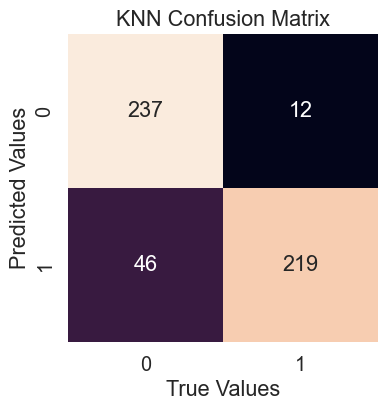

In [11]:
#Config Parameters:
knn_grid = [
                {
                    'n_neighbors':[1,2,4,8,10,20],
                    'weights':['uniform','distance'],
                    #'algorithm':['auto'],
                    'leaf_size':[2,4,8,20,40,80,100],
                    #'p':[2], 
                    #'metric':['minkowski'],
                    'n_jobs':[-1]
                }
             ]
startTime = time.time()
knn_t = auto_tune(knn_grid, KNeighborsClassifier(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("KNN Auto Tune Best Params:\n", knn_t)
print("")

knn = KNeighborsClassifier(**knn_t)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

knn_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['KNN', knn_cr])
print(knn_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
knn_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['KNN', knn_conf_matrix])
show_conf_matrix("KNN Confusion Matrix", conf_matrix_df)

## 2. Decision Trees Classifier (DTC)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tune Time: 0.4961s
DTC Auto Tune Best Params:
 {'splitter': 'random', 'random_state': 1, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None, 'criterion': 'log_loss', 'class_weight': None}

              precision    recall  f1-score   support

           0     0.8014    0.8916    0.8441       249
           1     0.8861    0.7925    0.8367       265

    accuracy                         0.8405       514
   macro avg     0.8438    0.8420    0.8404       514
weighted avg     0.8451    0.8405    0.8403       514



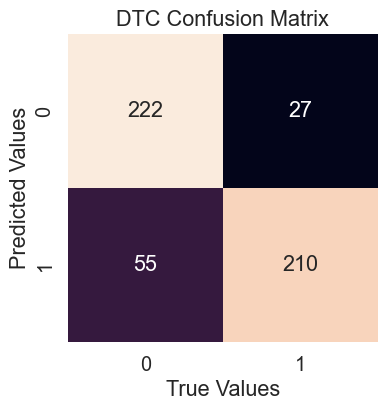

In [12]:
#Config Parameters:
dtc_grid = [
                {
                    'criterion':['gini', 'entropy','log_loss'],
                    'splitter':['best','random'],
                    'max_depth':[None],
                    'min_samples_split':[2,4,8,20,40,80,100],
                    'min_samples_leaf':[1,2,4,8,20,40,80,100],
                    #'min_weight_fraction_leaf':[0.0],
                    'max_features':[None,'sqrt','log2'],
                    'random_state':[1], 
                    'max_leaf_nodes':[None],
                    #'min_impurity_decrease':[0.0],
                    'class_weight':[None,'balanced'],
                    #'ccp_alpha':[0.0]
                }
             ]
startTime = time.time()
dtc_t = auto_tune(dtc_grid, DecisionTreeClassifier(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("DTC Auto Tune Best Params:\n", dtc_t)
print("")

dtc = DecisionTreeClassifier(**dtc_t) #default: no max depth
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)

dtc_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['DTC', dtc_cr])
print(dtc_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
dtc_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['DTC', dtc_conf_matrix])
show_conf_matrix("DTC Confusion Matrix", conf_matrix_df)

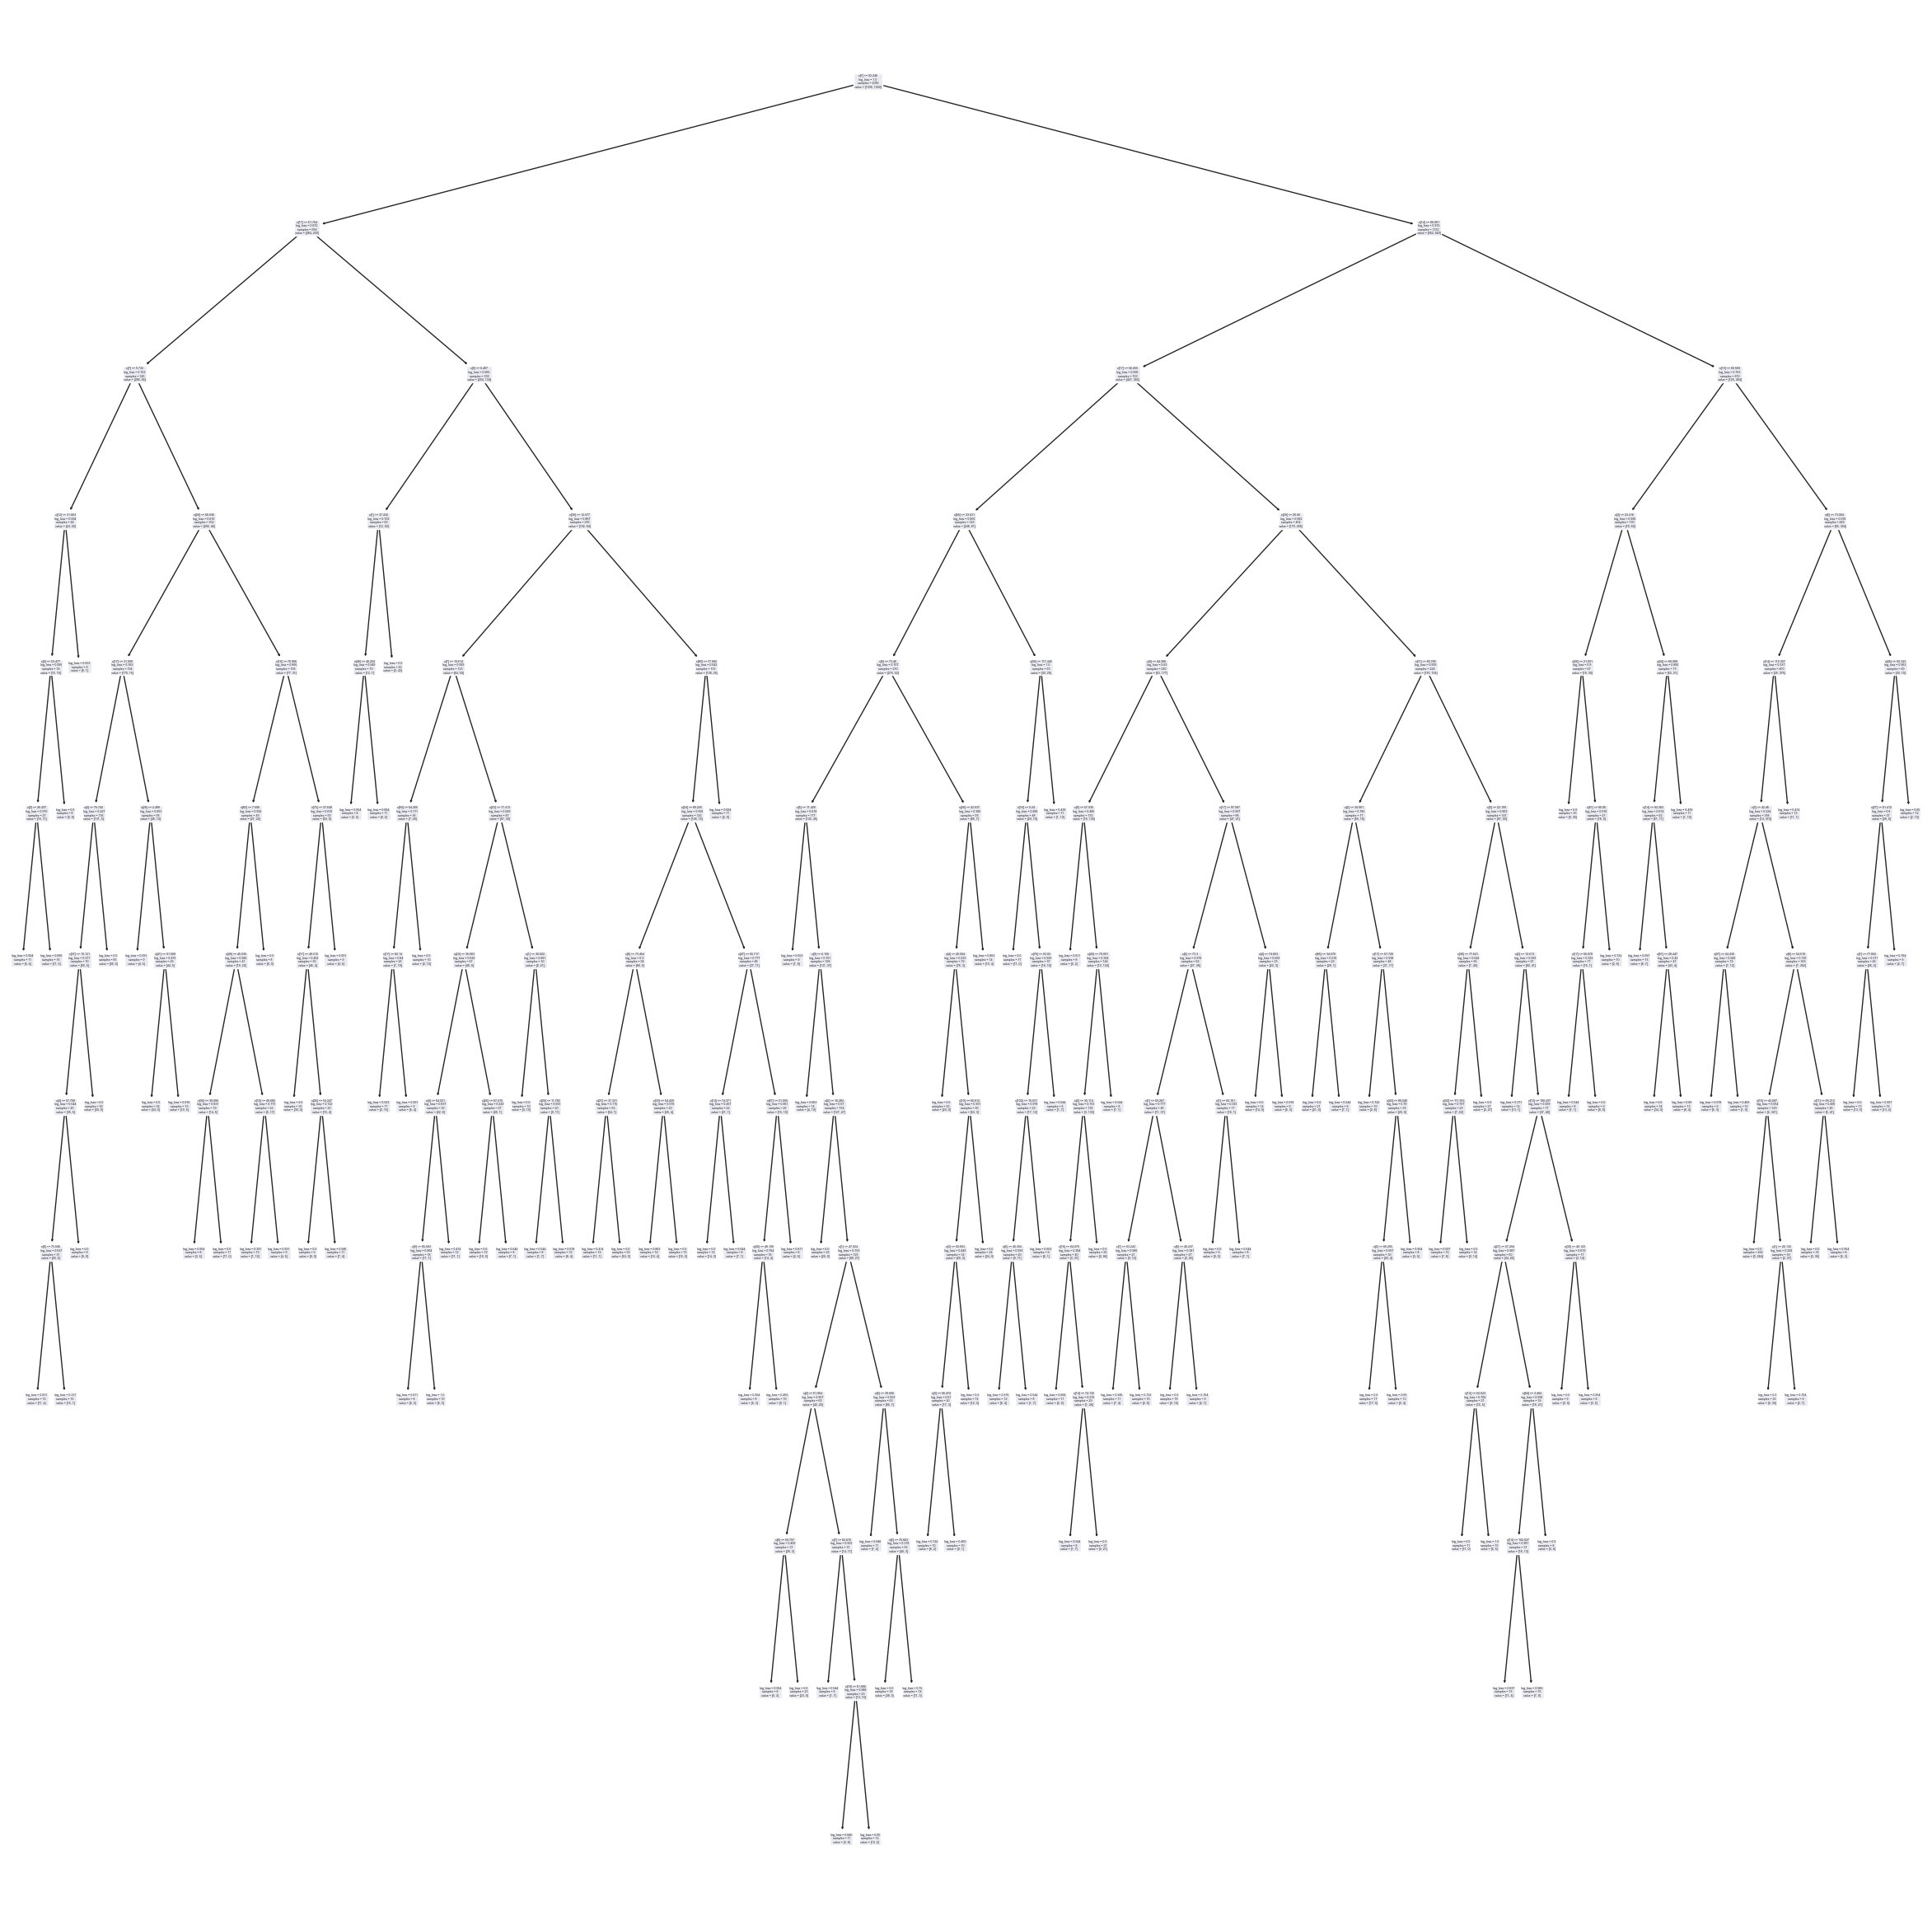

In [13]:
plt.figure(figsize=(30, 30))
plot_tree(dtc)
plt.show()

## 3. Logistic Regression

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.3s finished



Tune Time: 63.9053s
LR Auto Tune Best Params:
 {'verbose': True, 'tol': 0.001, 'solver': 'lbfgs', 'random_state': 1, 'penalty': 'l2', 'n_jobs': -1, 'max_iter': 1000000000, 'class_weight': None, 'C': 1}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.3s finished


              precision    recall  f1-score   support

           0     0.7256    0.8072    0.7643       249
           1     0.7975    0.7132    0.7530       265

    accuracy                         0.7588       514
   macro avg     0.7616    0.7602    0.7586       514
weighted avg     0.7627    0.7588    0.7584       514



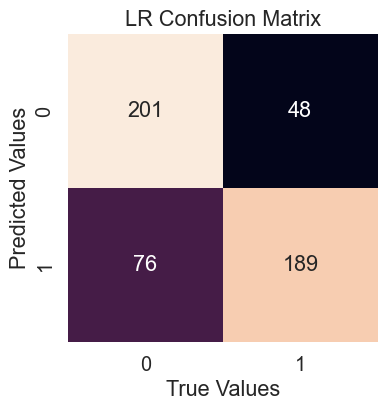

In [14]:
#Config Parameters:
lr_grid = [
                {
                    'penalty':[None,'l2'],
                    #'dual':[False],
                    'tol':[0.001],
                    'C':[1,10,100],
                    #'fit_intercept':[True, False],
                    #'intercept_scaling':[1],
                    'class_weight':[None,'balanced'],
                    'random_state':[1], 
                    'solver':['lbfgs','newton-cholesky'],
                    'max_iter':[1000000000],
                    #'multi_class':['auto'],
                    'n_jobs':[-1],
                    #'l1_ratio':[None]
                    'verbose':[True]
                }
             ]
startTime = time.time()
lr_t = auto_tune(lr_grid, LogisticRegression(), X_train, y_train, X_test,worker=-1)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("LR Auto Tune Best Params:\n", lr_t)
print("")

lr = LogisticRegression(**lr_t)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

lr_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['LR', lr_cr])
print(lr_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
lr_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['LR', lr_conf_matrix])
show_conf_matrix("LR Confusion Matrix", conf_matrix_df)

## 4. Support Vector Machine (SVM)*

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LibSVM]
Tune Time: 10.9501s
SVM Auto Tune Best Params:
 {'verbose': True, 'tol': 0.001, 'random_state': 1, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'coef0': 1.0, 'class_weight': None, 'cache_size': 512, 'C': 10}

[LibSVM]              precision    recall  f1-score   support

           0     0.8453    0.9438    0.8918       249
           1     0.9407    0.8377    0.8862       265

    accuracy                         0.8891       514
   macro avg     0.8930    0.8908    0.8890       514
weighted avg     0.8945    0.8891    0.8889       514



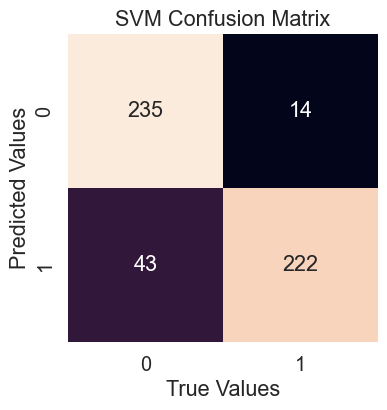

In [15]:
#Config Parameters:
svm_grid = [
                {
                    'C':[1,10,100],
                    'kernel':['poly','rbf','sigmoid'],
                    'degree':[2],
                    'gamma':['auto','scale'],
                    'coef0':[0.0,1.0],
                    #'shrinking':[True],
                    #'probability':[False],
                    'tol':[0.001], 
                    'cache_size':[512],
                    'class_weight':[None, 'balanced'],
                    #'max_iter':[-1],
                    #'decision_function_shape':['ovr'],
                    #'break_ties':[False],
                    'random_state':[1],
                    'verbose':[True]
                }
             ]
startTime = time.time()
svm_t = auto_tune(svm_grid, SVM(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("SVM Auto Tune Best Params:\n", svm_t)
print("")

svm = SVM(**svm_t)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

svm_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['SVM', svm_cr])
print(svm_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
svm_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['SVM', svm_conf_matrix])
show_conf_matrix("SVM Confusion Matrix", conf_matrix_df)

## 5. Random Forest*

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished



Tune Time: 41.2800s
RF Auto Tune Best Params:
 {'verbose': True, 'random_state': 1, 'n_jobs': -1, 'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': False}



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

           0     0.8464    0.9960    0.9151       249
           1     0.9955    0.8302    0.9053       265

    accuracy                         0.9105       514
   macro avg     0.9209    0.9131    0.9102       514
weighted avg     0.9233    0.9105    0.9101       514



[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


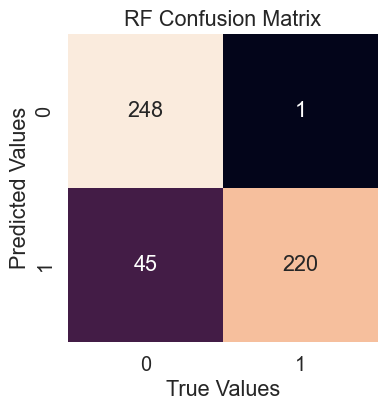

In [16]:
#Config Parameters:
rf_grid = [
                {
                    'n_estimators':[50,100,500],
                    'criterion':['gini','entropy','log_loss'],
                    #'max_depth':[None],
                    'min_samples_split':[2,4],
                    'min_samples_leaf':[1,2,4],
                    #'min_weight_fraction_leaf':[0.0],
                    'max_features':[None,'sqrt','log2'], 
                    #'max_leaf_nodes':[None],
                    #'min_impurity_decrease':[0.0],
                    'bootstrap':[False],
                    #'oob_score':[False],
                    'n_jobs':[-1],
                    'random_state':[1],
                    #'warm_start':[False],
                    'class_weight':[None, 'balanced','balanced_subsample'],
                    #'ccp_alpha':[0.0],
                    #'max_samples':[None]
                    'verbose':[True]
                }
             ]
startTime = time.time()
rf_t = auto_tune(rf_grid, RF(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("RF Auto Tune Best Params:\n", rf_t)
print("")

rf = RF(**rf_t)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

rf_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['RF', rf_cr])
print(rf_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
rf_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['RF', rf_conf_matrix])
show_conf_matrix("RF Confusion Matrix", conf_matrix_df)

## 6. GNB*

C:\Users\ejose\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Tune Time: 0.3784s
GNB Auto Tune Best Params:
 {'var_smoothing': 1e-08}

              precision    recall  f1-score   support

           0     0.6190    0.0522    0.0963       249
           1     0.5213    0.9698    0.6781       265

    accuracy                         0.5253       514
   macro avg     0.5702    0.5110    0.3872       514
weighted avg     0.5687    0.5253    0.3963       514



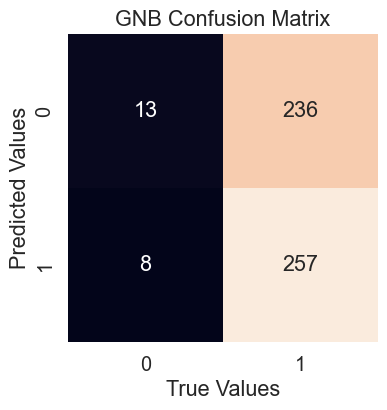

In [17]:
#Config Parameters:
gnb_grid = [
                {
                    #'priors':[None], 
                    'var_smoothing':[1e-05,1e-06,1e-07,1e-08,1e-09]
                }
             ]
startTime = time.time()
gnb_t = auto_tune(gnb_grid, GNB(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("GNB Auto Tune Best Params:\n", gnb_t)
print("")

gnb = GNB(**gnb_t)
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)

gnb_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['GNB', gnb_cr])
print(gnb_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
gnb_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['GNB', gnb_conf_matrix])
show_conf_matrix("GNB Confusion Matrix", conf_matrix_df)

## 7. AdaBoost*

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tune Time: 22.8574s
ADA Auto Tune Best Params:
 {'random_state': 1, 'n_estimators': 500, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}

              precision    recall  f1-score   support

           0     0.8958    0.9317    0.9134       249
           1     0.9333    0.8981    0.9154       265

    accuracy                         0.9144       514
   macro avg     0.9145    0.9149    0.9144       514
weighted avg     0.9151    0.9144    0.9144       514



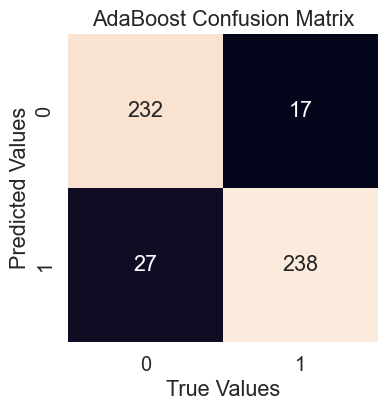

In [18]:
#Config Parameters:
ada_grid = [
                {
                    #'estimator':[None],
                    'n_estimators':[10,50,100,500],
                    'learning_rate':[0.8,0.9,1.0,1.1,1.2],
                    'algorithm':['SAMME','SAMME.R'],
                    'random_state':[1],
                    #'base_estimator':['deprecated']
                }
             ]
startTime = time.time()
ada_t = auto_tune(ada_grid, ADA(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("ADA Auto Tune Best Params:\n", ada_t)
print("")

ada = ADA(**ada_t)
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)

ada_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['AdaBoost', ada_cr])
print(ada_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
ada_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['AdaBoost', ada_conf_matrix])
show_conf_matrix("AdaBoost Confusion Matrix", conf_matrix_df)

## 8. MLP*

*Sort of a Neural Network like ML model.*

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tune Time: 28.3705s
MLP Auto Tune Best Params:
 {'verbose': True, 'tol': 0.001, 'solver': 'lbfgs', 'random_state': 1, 'max_iter': 100000, 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'hidden_layer_sizes': 50, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'tanh'}

              precision    recall  f1-score   support

           0     0.8051    0.8795    0.8407       249
           1     0.8760    0.8000    0.8363       265

    accuracy                         0.8385       514
   macro avg     0.8406    0.8398    0.8385       514
weighted avg     0.8417    0.8385    0.8384       514



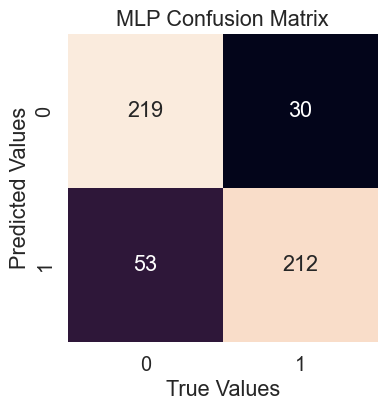

In [19]:
#Config Parameters:
mlp_grid = [
                {
                    'hidden_layer_sizes':[50,100],
                    'activation':['identity','logistic','tanh','relu'],
                    'solver':['lbfgs','sgd','adam'],
                    'alpha':[0.0001],
                    #'batch_size':['auto'],
                    'learning_rate':['constant','invscaling','adaptive'],
                    'learning_rate_init':[0.01],
                    #'power_t':[0.5],
                    'max_iter':[100000],
                    #'shuffle':[True],
                    'random_state':[1],
                    'tol':[0.001],
                    'verbose':[True],
                    #'warm_start':[False],
                    #'momentum':[0.9],
                    #'nesterovs_momentum':[True],
                    'early_stopping':[True],
                    #'validation_fraction':[0.1],
                    #'beta_1':[0.9],
                    #'beta_2':[0.999],
                    #'epsilon':[1e-8],
                    #'n_iter_no_change':[20],
                    #'max_fun':[15000]
                }
             ]
startTime = time.time()
mlp_t = auto_tune(mlp_grid, MLP(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("MLP Auto Tune Best Params:\n", mlp_t)
print("")

mlp = MLP(**mlp_t)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)

mlp_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['MLP', mlp_cr])
print(mlp_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
mlp_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['MLP', mlp_conf_matrix])
show_conf_matrix("MLP Confusion Matrix", conf_matrix_df)

## 9. Gradient Tree Boosting

Fitting 3 folds for each of 10 candidates, totalling 30 fits
      Iter       Train Loss   Remaining Time 
         1           1.3847            0.77s
         2           1.3830            0.88s
         3           1.3814            0.82s
         4           1.3798            0.80s
         5           1.3781            0.77s
         6           1.3765            0.74s
         7           1.3748            0.71s
         8           1.3732            0.69s
         9           1.3716            0.67s
        10           1.3700            0.65s
        20           1.3541            0.51s
        30           1.3389            0.33s
        40           1.3236            0.16s
        50           1.3090            0.00s

Tune Time: 12.1466s
GBT Auto Tune Best Params:
 {'verbose': True, 'tol': 0.001, 'solver': 'lbfgs', 'random_state': 1, 'max_iter': 100000, 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'hidden_layer_sizes': 50, 'early_stopping': True, 'alpha': 0.0001

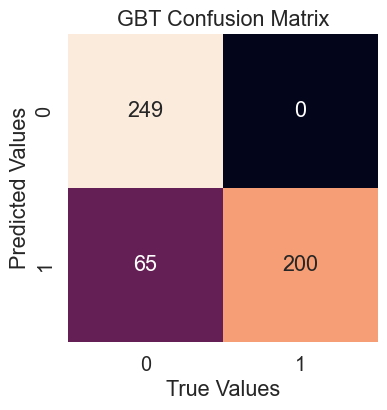

In [20]:
#Config Parameters:
gbt_grid = [
                {
                    'loss':['log_loss','exponential'],
                    'learning_rate':[0.01,0.001],
                    'n_estimators':[50,100],
                    #'subsample':[1],
                    'criterion':['friedman_mse', 'squared_error'],
                    'min_samples_split':[2,4,8,10],
                    'min_samples_leaf':[2,4,8,10],
                    #'min_weight_fraction_leaf':[0],
                    'max_depth':[3,None],
                    #'min_impurity_decrease':[0],
                    #'init':[None],
                    'random_state':[1],
                    'max_features':[None,'sqrt','log2'],
                    'verbose':[True],
                    'max_leaf_nodes':[None],
                    #'warm_start':[False],
                    #'validation_fraction':[0.1],
                    'n_iter_no_change':[10],
                    'tol':[0.001,0.0001],
                    #'ccp_alpha':[0.0]
                }
             ]
startTime = time.time()
gbt_t = auto_tune(gbt_grid, GBT(), X_train, y_train, X_test)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("GBT Auto Tune Best Params:\n", mlp_t)
print("")

gbt = GBT(**gbt_t)
gbt.fit(X_train,y_train)
y_pred = gbt.predict(X_test)

gbt_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['GBT', gbt_cr])
print(gbt_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
gbt_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['GBT', gbt_conf_matrix])
show_conf_matrix("GBT Confusion Matrix", conf_matrix_df)

## 10. Histogram Gradient Tree Boosting
*According to SKLearn's documentation, the model was inspired by LightGBM*

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Binning 0.002 GB of training data: 0.030 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, in 0.087s
[2/100] 

C:\Users\ejose\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


1 tree, 31 leaves, max depth = 11, in 0.089s
[3/100] 1 tree, 31 leaves, max depth = 12, in 0.093s
[4/100] 1 tree, 31 leaves, max depth = 10, in 0.087s
[5/100] 1 tree, 31 leaves, max depth = 9, in 0.092s
[6/100] 1 tree, 31 leaves, max depth = 10, in 0.086s
[7/100] 1 tree, 31 leaves, max depth = 11, in 0.084s
[8/100] 1 tree, 31 leaves, max depth = 12, in 0.088s
[9/100] 1 tree, 31 leaves, max depth = 11, in 0.084s
[10/100] 1 tree, 31 leaves, max depth = 11, in 0.086s
[11/100] 1 tree, 31 leaves, max depth = 11, in 0.091s
[12/100] 1 tree, 31 leaves, max depth = 10, in 0.084s
[13/100] 1 tree, 31 leaves, max depth = 9, in 0.094s
[14/100] 1 tree, 31 leaves, max depth = 10, in 0.081s
[15/100] 1 tree, 31 leaves, max depth = 11, in 0.084s
[16/100] 1 tree, 31 leaves, max depth = 12, in 0.085s
[17/100] 1 tree, 31 leaves, max depth = 11, in 0.082s
[18/100] 1 tree, 31 leaves, max depth = 11, in 0.077s
[19/100] 1 tree, 31 leaves, max depth = 11, in 0.086s
[20/100] 1 tree, 31 leaves, max depth = 13, in

[46/100] 1 tree, 31 leaves, max depth = 14, in 0.082s
[47/100] 1 tree, 31 leaves, max depth = 11, in 0.084s
[48/100] 1 tree, 31 leaves, max depth = 17, in 0.081s
[49/100] 1 tree, 31 leaves, max depth = 17, in 0.087s
[50/100] 1 tree, 31 leaves, max depth = 13, in 0.083s
[51/100] 1 tree, 31 leaves, max depth = 13, in 0.082s
[52/100] 1 tree, 31 leaves, max depth = 13, in 0.075s
[53/100] 1 tree, 31 leaves, max depth = 18, in 0.084s
[54/100] 1 tree, 31 leaves, max depth = 12, in 0.072s
[55/100] 1 tree, 31 leaves, max depth = 17, in 0.094s
[56/100] 1 tree, 31 leaves, max depth = 11, in 0.083s
[57/100] 1 tree, 31 leaves, max depth = 17, in 0.086s
[58/100] 1 tree, 31 leaves, max depth = 14, in 0.085s
[59/100] 1 tree, 31 leaves, max depth = 14, in 0.081s
[60/100] 1 tree, 31 leaves, max depth = 18, in 0.086s
[61/100] 1 tree, 31 leaves, max depth = 9, in 0.087s
[62/100] 1 tree, 31 leaves, max depth = 11, in 0.101s
[63/100] 1 tree, 31 leaves, max depth = 19, in 0.087s
[64/100] 1 tree, 31 leaves, m

[90/100] 1 tree, 31 leaves, max depth = 15, in 0.074s
[91/100] 1 tree, 31 leaves, max depth = 10, in 0.081s
[92/100] 1 tree, 31 leaves, max depth = 21, in 0.083s
[93/100] 1 tree, 31 leaves, max depth = 17, in 0.072s
[94/100] 1 tree, 31 leaves, max depth = 11, in 0.073s
[95/100] 1 tree, 31 leaves, max depth = 10, in 0.070s
[96/100] 1 tree, 31 leaves, max depth = 14, in 0.080s
[97/100] 1 tree, 31 leaves, max depth = 20, in 0.076s
[98/100] 1 tree, 31 leaves, max depth = 18, in 0.076s
[99/100] 1 tree, 31 leaves, max depth = 15, in 0.078s
[100/100] 1 tree, 31 leaves, max depth = 19, in 0.074s
Fit 100 trees in 7.918 s, (3100 total leaves)
Time spent computing histograms: 6.073s
Time spent finding best splits:  0.440s
Time spent applying splits:      0.508s
Time spent predicting:           0.009s
[CV 3/3] END class_weight=None, interaction_cst=None, learning_rate=0.1, max_iter=100, min_samples_leaf=10, random_state=1, tol=0.001, verbose=True;, score=0.914 total time=   7.8s
Binning 0.002 GB o

[25/100] 1 tree, 31 leaves, max depth = 11, in 0.073s
[26/100] 1 tree, 31 leaves, max depth = 12, in 0.068s
[27/100] 1 tree, 31 leaves, max depth = 13, in 0.066s
[28/100] 1 tree, 31 leaves, max depth = 10, in 0.071s
[29/100] 1 tree, 31 leaves, max depth = 13, in 0.069s
[30/100] 1 tree, 31 leaves, max depth = 13, in 0.071s
[31/100] 1 tree, 31 leaves, max depth = 11, in 0.079s
[32/100] 1 tree, 31 leaves, max depth = 11, in 0.065s
[33/100] 1 tree, 31 leaves, max depth = 13, in 0.071s
[34/100] 1 tree, 31 leaves, max depth = 11, in 0.076s
[35/100] 1 tree, 31 leaves, max depth = 11, in 0.071s
[36/100] 1 tree, 31 leaves, max depth = 16, in 0.069s
[37/100] 1 tree, 31 leaves, max depth = 15, in 0.069s
[38/100] 1 tree, 31 leaves, max depth = 12, in 0.066s
[39/100] 1 tree, 31 leaves, max depth = 13, in 0.068s
[40/100] 1 tree, 31 leaves, max depth = 14, in 0.062s
[41/100] 1 tree, 31 leaves, max depth = 13, in 0.075s
[42/100] 1 tree, 31 leaves, max depth = 16, in 0.065s
[43/100] 1 tree, 31 leaves, 

[69/100] 1 tree, 31 leaves, max depth = 12, in 0.068s
[70/100] 1 tree, 31 leaves, max depth = 20, in 0.068s
[71/100] 1 tree, 31 leaves, max depth = 18, in 0.073s
[72/100] 1 tree, 31 leaves, max depth = 18, in 0.073s
[73/100] 1 tree, 31 leaves, max depth = 19, in 0.069s
[74/100] 1 tree, 31 leaves, max depth = 18, in 0.066s
[75/100] 1 tree, 31 leaves, max depth = 13, in 0.066s
[76/100] 1 tree, 31 leaves, max depth = 16, in 0.069s
[77/100] 1 tree, 31 leaves, max depth = 20, in 0.071s
[78/100] 1 tree, 31 leaves, max depth = 12, in 0.069s
[79/100] 1 tree, 31 leaves, max depth = 17, in 0.074s
[80/100] 1 tree, 31 leaves, max depth = 10, in 0.069s
[81/100] 1 tree, 31 leaves, max depth = 12, in 0.078s
[82/100] 1 tree, 31 leaves, max depth = 19, in 0.068s
[83/100] 1 tree, 31 leaves, max depth = 18, in 0.070s
[84/100] 1 tree, 31 leaves, max depth = 14, in 0.073s
[85/100] 1 tree, 31 leaves, max depth = 11, in 0.072s
[86/100] 1 tree, 31 leaves, max depth = 16, in 0.069s
[87/100] 1 tree, 31 leaves, 

[4/100] 1 tree, 31 leaves, max depth = 12, in 0.064s
[5/100] 1 tree, 31 leaves, max depth = 11, in 0.062s
[6/100] 1 tree, 30 leaves, max depth = 12, in 0.055s
[7/100] 1 tree, 31 leaves, max depth = 10, in 0.057s
[8/100] 1 tree, 31 leaves, max depth = 10, in 0.062s
[9/100] 1 tree, 31 leaves, max depth = 11, in 0.062s
[10/100] 1 tree, 31 leaves, max depth = 13, in 0.065s
[11/100] 1 tree, 31 leaves, max depth = 13, in 0.062s
[12/100] 1 tree, 31 leaves, max depth = 12, in 0.061s
[13/100] 1 tree, 31 leaves, max depth = 9, in 0.061s
[14/100] 1 tree, 31 leaves, max depth = 9, in 0.057s
[15/100] 1 tree, 31 leaves, max depth = 10, in 0.061s
[16/100] 1 tree, 31 leaves, max depth = 9, in 0.059s
[17/100] 1 tree, 31 leaves, max depth = 9, in 0.059s
[18/100] 1 tree, 31 leaves, max depth = 10, in 0.064s
[19/100] 1 tree, 31 leaves, max depth = 12, in 0.061s
[20/100] 1 tree, 31 leaves, max depth = 10, in 0.058s
[21/100] 1 tree, 31 leaves, max depth = 12, in 0.062s
[22/100] 1 tree, 31 leaves, max depth 

[48/100] 1 tree, 31 leaves, max depth = 9, in 0.055s
[49/100] 1 tree, 31 leaves, max depth = 17, in 0.064s
[50/100] 1 tree, 31 leaves, max depth = 10, in 0.063s
[51/100] 1 tree, 31 leaves, max depth = 16, in 0.064s
[52/100] 1 tree, 31 leaves, max depth = 12, in 0.055s
[53/100] 1 tree, 31 leaves, max depth = 16, in 0.059s
[54/100] 1 tree, 31 leaves, max depth = 12, in 0.058s
[55/100] 1 tree, 31 leaves, max depth = 19, in 0.070s
[56/100] 1 tree, 31 leaves, max depth = 14, in 0.052s
[57/100] 1 tree, 31 leaves, max depth = 10, in 0.063s
[58/100] 1 tree, 31 leaves, max depth = 13, in 0.060s
[59/100] 1 tree, 31 leaves, max depth = 10, in 0.058s
[60/100] 1 tree, 31 leaves, max depth = 16, in 0.064s
[61/100] 1 tree, 31 leaves, max depth = 17, in 0.064s
[62/100] 1 tree, 31 leaves, max depth = 12, in 0.061s
[63/100] 1 tree, 31 leaves, max depth = 17, in 0.063s
[64/100] 1 tree, 31 leaves, max depth = 12, in 0.066s
[65/100] 1 tree, 31 leaves, max depth = 13, in 0.059s
[66/100] 1 tree, 31 leaves, m

[92/100] 1 tree, 31 leaves, max depth = 17, in 0.076s
[93/100] 1 tree, 31 leaves, max depth = 14, in 0.081s
[94/100] 1 tree, 31 leaves, max depth = 16, in 0.078s
[95/100] 1 tree, 31 leaves, max depth = 15, in 0.079s
[96/100] 1 tree, 31 leaves, max depth = 22, in 0.081s
[97/100] 1 tree, 31 leaves, max depth = 15, in 0.077s
[98/100] 1 tree, 31 leaves, max depth = 11, in 0.081s
[99/100] 1 tree, 31 leaves, max depth = 18, in 0.076s
[100/100] 1 tree, 31 leaves, max depth = 17, in 0.076s
Fit 100 trees in 7.958 s, (3100 total leaves)
Time spent computing histograms: 6.100s
Time spent finding best splits:  0.449s
Time spent applying splits:      0.520s
Time spent predicting:           0.009s
[CV 1/3] END class_weight=balanced, interaction_cst=None, learning_rate=0.1, max_iter=100, min_samples_leaf=10, random_state=1, tol=0.001, verbose=True;, score=0.910 total time=   7.9s
Binning 0.002 GB of training data: 0.033 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, in 

[27/100] 1 tree, 31 leaves, max depth = 9, in 0.077s
[28/100] 1 tree, 31 leaves, max depth = 9, in 0.077s
[29/100] 1 tree, 31 leaves, max depth = 9, in 0.079s
[30/100] 1 tree, 31 leaves, max depth = 9, in 0.079s
[31/100] 1 tree, 31 leaves, max depth = 9, in 0.075s
[32/100] 1 tree, 31 leaves, max depth = 10, in 0.074s
[33/100] 1 tree, 31 leaves, max depth = 9, in 0.078s
[34/100] 1 tree, 31 leaves, max depth = 10, in 0.077s
[35/100] 1 tree, 31 leaves, max depth = 9, in 0.078s
[36/100] 1 tree, 31 leaves, max depth = 7, in 0.076s
[37/100] 1 tree, 31 leaves, max depth = 12, in 0.086s
[38/100] 1 tree, 31 leaves, max depth = 9, in 0.080s
[39/100] 1 tree, 31 leaves, max depth = 9, in 0.089s
[40/100] 1 tree, 31 leaves, max depth = 11, in 0.077s
[41/100] 1 tree, 31 leaves, max depth = 11, in 0.080s
[42/100] 1 tree, 31 leaves, max depth = 14, in 0.076s
[43/100] 1 tree, 31 leaves, max depth = 10, in 0.087s
[44/100] 1 tree, 31 leaves, max depth = 15, in 0.079s
[45/100] 1 tree, 31 leaves, max depth 

[71/100] 1 tree, 31 leaves, max depth = 14, in 0.072s
[72/100] 1 tree, 31 leaves, max depth = 19, in 0.072s
[73/100] 1 tree, 31 leaves, max depth = 22, in 0.074s
[74/100] 1 tree, 31 leaves, max depth = 15, in 0.064s
[75/100] 1 tree, 31 leaves, max depth = 19, in 0.075s
[76/100] 1 tree, 31 leaves, max depth = 10, in 0.066s
[77/100] 1 tree, 31 leaves, max depth = 17, in 0.067s
[78/100] 1 tree, 31 leaves, max depth = 10, in 0.063s
[79/100] 1 tree, 31 leaves, max depth = 19, in 0.068s
[80/100] 1 tree, 31 leaves, max depth = 14, in 0.072s
[81/100] 1 tree, 31 leaves, max depth = 19, in 0.070s
[82/100] 1 tree, 31 leaves, max depth = 13, in 0.067s
[83/100] 1 tree, 31 leaves, max depth = 17, in 0.074s
[84/100] 1 tree, 31 leaves, max depth = 18, in 0.066s
[85/100] 1 tree, 31 leaves, max depth = 18, in 0.065s
[86/100] 1 tree, 31 leaves, max depth = 17, in 0.068s
[87/100] 1 tree, 31 leaves, max depth = 12, in 0.063s
[88/100] 1 tree, 31 leaves, max depth = 19, in 0.067s
[89/100] 1 tree, 31 leaves, 

[6/100] 1 tree, 31 leaves, max depth = 13, in 0.063s
[7/100] 1 tree, 31 leaves, max depth = 10, in 0.062s
[8/100] 1 tree, 31 leaves, max depth = 10, in 0.061s
[9/100] 1 tree, 31 leaves, max depth = 15, in 0.069s
[10/100] 1 tree, 31 leaves, max depth = 10, in 0.064s
[11/100] 1 tree, 31 leaves, max depth = 9, in 0.064s
[12/100] 1 tree, 31 leaves, max depth = 12, in 0.070s
[13/100] 1 tree, 31 leaves, max depth = 10, in 0.071s
[14/100] 1 tree, 31 leaves, max depth = 11, in 0.066s
[15/100] 1 tree, 31 leaves, max depth = 9, in 0.066s
[16/100] 1 tree, 31 leaves, max depth = 12, in 0.061s
[17/100] 1 tree, 31 leaves, max depth = 8, in 0.070s
[18/100] 1 tree, 31 leaves, max depth = 13, in 0.067s
[19/100] 1 tree, 31 leaves, max depth = 11, in 0.077s
[20/100] 1 tree, 31 leaves, max depth = 13, in 0.064s
[21/100] 1 tree, 31 leaves, max depth = 8, in 0.059s
[22/100] 1 tree, 31 leaves, max depth = 10, in 0.067s
[23/100] 1 tree, 31 leaves, max depth = 8, in 0.067s
[24/100] 1 tree, 31 leaves, max depth

[50/100] 1 tree, 31 leaves, max depth = 10, in 0.058s
[51/100] 1 tree, 31 leaves, max depth = 14, in 0.076s
[52/100] 1 tree, 31 leaves, max depth = 17, in 0.061s
[53/100] 1 tree, 31 leaves, max depth = 16, in 0.064s
[54/100] 1 tree, 31 leaves, max depth = 16, in 0.064s
[55/100] 1 tree, 31 leaves, max depth = 14, in 0.068s
[56/100] 1 tree, 30 leaves, max depth = 13, in 0.051s
[57/100] 1 tree, 31 leaves, max depth = 13, in 0.068s
[58/100] 1 tree, 31 leaves, max depth = 11, in 0.065s
[59/100] 1 tree, 31 leaves, max depth = 17, in 0.061s
[60/100] 1 tree, 31 leaves, max depth = 19, in 0.059s
[61/100] 1 tree, 31 leaves, max depth = 16, in 0.064s
[62/100] 1 tree, 31 leaves, max depth = 17, in 0.060s
[63/100] 1 tree, 31 leaves, max depth = 18, in 0.063s
[64/100] 1 tree, 31 leaves, max depth = 19, in 0.060s
[65/100] 1 tree, 31 leaves, max depth = 11, in 0.064s
[66/100] 1 tree, 31 leaves, max depth = 10, in 0.056s
[67/100] 1 tree, 31 leaves, max depth = 15, in 0.063s
[68/100] 1 tree, 31 leaves, 

[94/100] 1 tree, 31 leaves, max depth = 11, in 0.062s
[95/100] 1 tree, 31 leaves, max depth = 16, in 0.061s
[96/100] 1 tree, 31 leaves, max depth = 12, in 0.057s
[97/100] 1 tree, 31 leaves, max depth = 17, in 0.057s
[98/100] 1 tree, 31 leaves, max depth = 20, in 0.059s
[99/100] 1 tree, 31 leaves, max depth = 14, in 0.065s
[100/100] 1 tree, 31 leaves, max depth = 16, in 0.065s
Fit 100 trees in 6.121 s, (3094 total leaves)
Time spent computing histograms: 4.599s
Time spent finding best splits:  0.280s
Time spent applying splits:      0.486s
Time spent predicting:           0.009s
[CV 2/3] END class_weight=balanced, interaction_cst=None, learning_rate=0.1, max_iter=100, min_samples_leaf=30, random_state=1, tol=0.001, verbose=True;, score=0.896 total time=   6.0s
Binning 0.002 GB of training data: 0.033 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 27 leaves, max depth = 9, in 0.051s
[2/100] 1 tree, 31 leaves, max depth = 12, in 0.048s
[3/100] 1 tree, 31 leaves, max depth = 9, in 0.05

[29/100] 1 tree, 31 leaves, max depth = 9, in 0.085s
[30/100] 1 tree, 31 leaves, max depth = 9, in 0.078s
[31/100] 1 tree, 31 leaves, max depth = 18, in 0.089s
[32/100] 1 tree, 31 leaves, max depth = 14, in 0.080s
[33/100] 1 tree, 31 leaves, max depth = 16, in 0.091s
[34/100] 1 tree, 31 leaves, max depth = 10, in 0.082s
[35/100] 1 tree, 31 leaves, max depth = 13, in 0.092s
[36/100] 1 tree, 31 leaves, max depth = 16, in 0.080s
[37/100] 1 tree, 31 leaves, max depth = 10, in 0.083s
[38/100] 1 tree, 31 leaves, max depth = 12, in 0.076s
[39/100] 1 tree, 31 leaves, max depth = 15, in 0.087s
[40/100] 1 tree, 31 leaves, max depth = 10, in 0.078s
[41/100] 1 tree, 31 leaves, max depth = 11, in 0.079s
[42/100] 1 tree, 31 leaves, max depth = 14, in 0.077s
[43/100] 1 tree, 31 leaves, max depth = 13, in 0.078s
[44/100] 1 tree, 31 leaves, max depth = 14, in 0.078s
[45/100] 1 tree, 31 leaves, max depth = 14, in 0.085s
[46/100] 1 tree, 31 leaves, max depth = 13, in 0.075s
[47/100] 1 tree, 31 leaves, ma

[71/100] 1 tree, 31 leaves, max depth = 18, in 0.083s
[72/100] 1 tree, 31 leaves, max depth = 16, in 0.079s
[73/100] 1 tree, 31 leaves, max depth = 11, in 0.075s
[74/100] 1 tree, 31 leaves, max depth = 19, in 0.076s
[75/100] 1 tree, 31 leaves, max depth = 19, in 0.079s
[76/100] 1 tree, 31 leaves, max depth = 17, in 0.075s
[77/100] 1 tree, 31 leaves, max depth = 11, in 0.081s
[78/100] 1 tree, 31 leaves, max depth = 15, in 0.075s
[79/100] 1 tree, 31 leaves, max depth = 13, in 0.075s
[80/100] 1 tree, 31 leaves, max depth = 17, in 0.092s
[81/100] 1 tree, 31 leaves, max depth = 17, in 0.081s
[82/100] 1 tree, 31 leaves, max depth = 13, in 0.084s
[83/100] 1 tree, 31 leaves, max depth = 17, in 0.078s
[84/100] 1 tree, 31 leaves, max depth = 19, in 0.082s
[85/100] 1 tree, 31 leaves, max depth = 16, in 0.084s
[86/100] 1 tree, 31 leaves, max depth = 20, in 0.084s
[87/100] 1 tree, 31 leaves, max depth = 16, in 0.079s
[88/100] 1 tree, 31 leaves, max depth = 22, in 0.084s
[89/100] 1 tree, 31 leaves, 

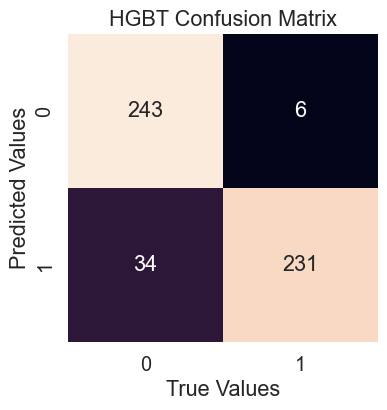

In [21]:
#Config Parameters:
hgbt_grid = [ #Due to time constraints and computing limitations, the available config parameters are very minimal
                {
                    #'loss':['log_loss'],
                    'learning_rate':[0.1],
                    'max_iter':[100],
                    #'max_leaf_nodes':[None],
                    #'max_depth':[None],
                    'min_samples_leaf':[10,20,30],
                    #'l2_regularization':[0],
                    #'max_bins':[255],
                    #'categorical_features':[None],
                    #'monotonic_cst':[None],
                    'interaction_cst':[None],
                    #'warm_start':[False],
                    #'early_stopping':['auto'],
                    #'scoring':['loss'],
                    #'validation_fraction':[0.1],
                    #'n_iter_no_change':[10],
                    'tol':[0.001],
                    'verbose':[True],
                    'random_state':[1],
                    'class_weight':[None,'balanced']
                }
             ]
startTime = time.time()
hgbt_t = auto_tune(hgbt_grid, HGBT(), X_train, y_train, X_test,worker=1)
print(f"Tune Time: {time.time()-startTime:.4f}s")
print("HGBT Auto Tune Best Params:\n", mlp_t)
print("")

hgbt = HGBT(**hgbt_t)
hgbt.fit(X_train,y_train)
y_pred = hgbt.predict(X_test)

hgbt_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['HGBT', hgbt_cr])
print(hgbt_cr)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
hgbt_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['HGBT', hgbt_conf_matrix])
show_conf_matrix("HGBT Confusion Matrix", conf_matrix_df)

# Comparison of Machine Learning Models

## 1. Stratified K-Folds Test

For this example, StratifiedKFold will be used to as suppose to the normal K-Folds in order *"to ensure that relative class frequencies are effectively sustained in each train and validation fold when using stratified sampling rather than random sampling"*.

**Reference:**

Prusty, S., Patnaik, S., & Dash, S. K. (2022). *SKCV: Stratified K-fold cross-validation on ML classifiers for predicting cervical cancer*. Frontiers in Nanotechnology, 4. https://www.frontiersin.org/articles/10.3389/fnano.2022.972421

In [22]:
splits = 10
kf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
model_label = ["KNN", "DTC", "LR", "SVM", "RF", "GNB", "AdaB", "MLP", "GBT", "HGBT"] #Don't change ordering
models = [knn, dtc, lr, svm, rf, gnb, ada, mlp, gbt, hgbt]
metric_label = ["Accuracy", "F1-Score (Weighted)", "Precision", "Recall", "ROC_AUC"]

def header():
    print(f"-----------------------------------------------------------------------------------------------")
    print(f"Fold   KNN      DTC      LR       SVM      RF       GNB      AdaB     MLP      GBT      HGBT   ")
    print(f"-----------------------------------------------------------------------------------------------")

def print_results(kfold_results, splits):
    header()
    for m in range(len(metric_label)): #Per Metric
        ave = [0,0,0,0,0,0,0,0,0,0] #Per model basis
        print("Metric:", metric_label[m])
        print("PER FOLD")
        for k in kfold_results: #Per Model
            out = ""
            for ksub in range(len(k)): #Per Fold of Model
                if ksub == 0:
                    out += f"{k[ksub]}      "
                else:
                    out += f"{k[ksub][m]:.4f}   "
                    ave[ksub-1] += k[ksub][m]
            print(out)
        out = "AVE    "
        print("AVERAGE")
        for a in ave:
            average = (a/splits)
            out += (f"{average:.4f}   ")
        print(out)
        print("") 
    
def kfolds(X,y):
    global model_label
    global models
    global splits
    total_test_index = 0
    kfold_results = []
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        sublist = [i]
        axis = 0 

        # Extract from the dataframe based on the given indeces
        training_set = np.take(X, train_index, axis)
        training_set_labels = np.take(y, train_index, axis)
        test_set = np.take(X, test_index, axis)
        test_set_labels = np.take(y, test_index, axis)

        total_test_index += len(test_set)
        
        for m in range(len(models)):
            print(f"{datetime.datetime.now()} Fold {i}: {model_label[m]} Running...")
            startTime = time.time()
            models[m].fit(training_set,training_set_labels)
            train_timers[m] += time.time()-startTime
            startTime = time.time()
            m_pred = models[m].predict(test_set)
            predict_timers[m] += time.time()-startTime
            sublist.append([round(accuracy_score(test_set_labels, m_pred),4),
                            round(f1_score(test_set_labels, m_pred, average='weighted'),4),
                            round(precision_score(test_set_labels, m_pred,zero_division=0),4),
                            round(recall_score(test_set_labels, m_pred),4),
                            round(roc_auc_score(test_set_labels, m_pred),4)
                           ])
        kfold_results.append(sublist)
        print(f"{datetime.datetime.now()} Fold {i:0.0f}: FINISHED")
    
    
    print("")
    print_results(kfold_results, splits)
    header()
    
    print("")
    print("Average Model Training Speed:")
    for train in range(len(train_timers)):
        train_timers[train] = [model_label[train], train_timers[train]/10]
    for t in train_timers:
        print(f"{t[0]:8s}: {t[1]:.4f}s")
    print("")
    
    print("Average Model Prediction Speed:")
    for predict in range(len(predict_timers)):
        predict_timers[predict] = [model_label[predict], predict_timers[predict]/total_test_index/10*1000]
    for p in predict_timers:
        print(f"{p[0]:8s}: {p[1]:.4f}ms")
    print("")

In [23]:
train_timers = [0,0,0,0,0,0,0,0,0,0]
predict_timers = [0,0,0,0,0,0,0,0,0,0]
kfolds(X,y)

2023-08-23 12:18:52.525903 Fold 0: KNN Running...
2023-08-23 12:18:52.587447 Fold 0: DTC Running...
2023-08-23 12:18:52.639442 Fold 0: LR Running...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.3s finished


2023-08-23 12:19:13.651684 Fold 0: SVM Running...
[LibSVM]2023-08-23 12:19:14.051922 Fold 0: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:19:16.318082 Fold 0: GNB Running...
2023-08-23 12:19:16.352746 Fold 0: AdaB Running...
2023-08-23 12:19:22.346067 Fold 0: MLP Running...
2023-08-23 12:19:36.631229 Fold 0: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3848            0.77s
         2           1.3831            0.75s
         3           1.3816            0.98s
         4           1.3799            0.91s
         5           1.3783            0.85s
         6           1.3766            0.80s
         7           1.3750            0.77s
         8           1.3733            0.82s
         9           1.3717            0.78s
        10           1.3701            0.77s
        20           1.3545            0.55s
        30           1.3389            0.36s
        40           1.3234            0.18s
        50           1.3083            0.00s
2023-08-23 12:19:37.585430 Fold 0: HGBT Running...
Binning 0.003 GB of training data: 0.032 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.4s finished


2023-08-23 12:20:12.048891 Fold 1: SVM Running...
[LibSVM]2023-08-23 12:20:12.455286 Fold 1: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:20:14.704611 Fold 1: GNB Running...
2023-08-23 12:20:14.730051 Fold 1: AdaB Running...
2023-08-23 12:20:20.765180 Fold 1: MLP Running...
2023-08-23 12:20:34.096041 Fold 1: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3847            0.69s
         2           1.3831            0.77s
         3           1.3815            0.80s
         4           1.3799            0.79s
         5           1.3783            0.79s
         6           1.3767            0.78s
         7           1.3751            0.78s
         8           1.3735            0.83s
         9           1.3719            0.83s
        10           1.3702            0.81s
        20           1.3547            0.57s
        30           1.3391            0.38s
        40           1.3239            0.19s
        50           1.3089            0.00s
2023-08-23 12:20:35.038797 Fold 1: HGBT Running...
Binning 0.003 GB of training data: 0.027 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   32.6s finished


2023-08-23 12:21:16.672480 Fold 2: SVM Running...
[LibSVM]2023-08-23 12:21:17.081615 Fold 2: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:21:19.388473 Fold 2: GNB Running...
2023-08-23 12:21:19.418474 Fold 2: AdaB Running...
2023-08-23 12:21:25.776684 Fold 2: MLP Running...
2023-08-23 12:21:35.890243 Fold 2: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3846            0.77s
         2           1.3830            0.75s
         3           1.3813            0.73s
         4           1.3797            0.90s
         5           1.3780            0.85s
         6           1.3767            0.81s
         7           1.3751            0.78s
         8           1.3735            0.82s
         9           1.3720            0.86s
        10           1.3703            0.87s
        20           1.3544            0.59s
        30           1.3388            0.39s
        40           1.3236            0.20s
        50           1.3087            0.00s
2023-08-23 12:21:36.856596 Fold 2: HGBT Running...
Binning 0.003 GB of training data: 0.039 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.0s finished


2023-08-23 12:22:15.554741 Fold 3: SVM Running...
[LibSVM]2023-08-23 12:22:15.996105 Fold 3: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:22:18.285175 Fold 3: GNB Running...
2023-08-23 12:22:18.316180 Fold 3: AdaB Running...
2023-08-23 12:22:24.404893 Fold 3: MLP Running...
2023-08-23 12:22:33.286542 Fold 3: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3847            0.74s
         2           1.3831            0.98s
         3           1.3814            1.17s
         4           1.3798            1.16s
         5           1.3781            1.11s
         6           1.3765            1.06s
         7           1.3748            1.10s
         8           1.3732            1.07s
         9           1.3716            1.02s
        10           1.3699            0.97s
        20           1.3539            0.64s
        30           1.3384            0.40s
        40           1.3228            0.20s
        50           1.3076            0.00s
2023-08-23 12:22:34.280338 Fold 3: HGBT Running...
Binning 0.003 GB of training data: 0.032 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.4s finished


2023-08-23 12:23:09.344625 Fold 4: SVM Running...
[LibSVM]2023-08-23 12:23:09.761625 Fold 4: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:23:12.026128 Fold 4: GNB Running...
2023-08-23 12:23:12.056770 Fold 4: AdaB Running...
2023-08-23 12:23:18.158320 Fold 4: MLP Running...
2023-08-23 12:23:31.345356 Fold 4: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3846            1.13s
         2           1.3831            0.93s
         3           1.3814            1.02s
         4           1.3798            0.99s
         5           1.3782            0.95s
         6           1.3768            0.88s
         7           1.3752            0.85s
         8           1.3737            0.83s
         9           1.3728            0.81s
        10           1.3712            0.79s
        20           1.3555            0.59s
        30           1.3402            0.39s
        40           1.3249            0.19s
        50           1.3103            0.00s
2023-08-23 12:23:32.331169 Fold 4: HGBT Running...
Binning 0.003 GB of training data: 0.028 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.5s finished


2023-08-23 12:24:11.651584 Fold 5: SVM Running...
[LibSVM]2023-08-23 12:24:12.095098 Fold 5: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:24:14.541933 Fold 5: GNB Running...
2023-08-23 12:24:14.565933 Fold 5: AdaB Running...
2023-08-23 12:24:21.322427 Fold 5: MLP Running...
2023-08-23 12:24:29.857667 Fold 5: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3847            1.08s
         2           1.3831            1.21s
         3           1.3815            1.26s
         4           1.3799            1.21s
         5           1.3783            1.22s
         6           1.3766            1.18s
         7           1.3751            1.20s
         8           1.3734            1.17s
         9           1.3718            1.14s
        10           1.3701            1.11s
        20           1.3541            0.79s
        30           1.3385            0.52s
        40           1.3228            0.26s
        50           1.3075            0.00s
2023-08-23 12:24:31.109169 Fold 5: HGBT Running...
Binning 0.003 GB of training data: 0.036 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   28.8s finished


2023-08-23 12:25:10.151911 Fold 6: SVM Running...
[LibSVM]2023-08-23 12:25:10.590580 Fold 6: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:25:12.880707 Fold 6: GNB Running...
2023-08-23 12:25:12.903708 Fold 6: AdaB Running...
2023-08-23 12:25:18.939826 Fold 6: MLP Running...
2023-08-23 12:25:29.749387 Fold 6: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3847            0.69s
         2           1.3830            0.80s
         3           1.3813            0.85s
         4           1.3797            0.86s
         5           1.3782            0.88s
         6           1.3766            0.92s
         7           1.3750            0.90s
         8           1.3735            0.86s
         9           1.3719            0.84s
        10           1.3704            0.82s
        20           1.3547            0.60s
        30           1.3391            0.39s
        40           1.3238            0.19s
        50           1.3087            0.00s
2023-08-23 12:25:30.718693 Fold 6: HGBT Running...
Binning 0.003 GB of training data: 0.035 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   27.7s finished


2023-08-23 12:26:07.561308 Fold 7: SVM Running...
[LibSVM]2023-08-23 12:26:08.001465 Fold 7: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:26:10.272424 Fold 7: GNB Running...
2023-08-23 12:26:10.297422 Fold 7: AdaB Running...
2023-08-23 12:26:16.327249 Fold 7: MLP Running...
2023-08-23 12:26:27.274714 Fold 7: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3846            0.77s
         2           1.3829            0.75s
         3           1.3813            0.99s
         4           1.3797            0.90s
         5           1.3780            0.99s
         6           1.3765            0.92s
         7           1.3748            0.90s
         8           1.3736            0.83s
         9           1.3719            0.87s
        10           1.3703            0.85s
        20           1.3542            0.60s
        30           1.3386            0.39s
        40           1.3232            0.19s
        50           1.3079            0.00s
2023-08-23 12:26:28.254954 Fold 7: HGBT Running...
Binning 0.003 GB of training data: 0.027 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.9s finished


2023-08-23 12:27:03.740549 Fold 8: SVM Running...
[LibSVM]2023-08-23 12:27:04.300066 Fold 8: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:27:06.612870 Fold 8: GNB Running...
2023-08-23 12:27:06.638237 Fold 8: AdaB Running...
2023-08-23 12:27:12.690737 Fold 8: MLP Running...
2023-08-23 12:27:22.464241 Fold 8: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3847            0.76s
         2           1.3830            0.85s
         3           1.3814            0.87s
         4           1.3798            0.87s
         5           1.3781            0.87s
         6           1.3766            0.86s
         7           1.3750            0.91s
         8           1.3734            0.93s
         9           1.3718            0.89s
        10           1.3701            0.87s
        20           1.3543            0.61s
        30           1.3386            0.40s
        40           1.3231            0.19s
        50           1.3081            0.00s
2023-08-23 12:27:23.443532 Fold 8: HGBT Running...
Binning 0.003 GB of training data: 0.035 s
Fitting gradient boosted roun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.4s finished


2023-08-23 12:27:59.530171 Fold 9: SVM Running...
[LibSVM]2023-08-23 12:27:59.952799 Fold 9: RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


2023-08-23 12:28:02.241848 Fold 9: GNB Running...
2023-08-23 12:28:02.266290 Fold 9: AdaB Running...
2023-08-23 12:28:08.485383 Fold 9: MLP Running...
2023-08-23 12:28:15.870983 Fold 9: GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3846            0.77s
         2           1.3830            0.75s
         3           1.3814            0.98s
         4           1.3800            0.90s
         5           1.3785            0.85s
         6           1.3770            0.81s
         7           1.3754            0.87s
         8           1.3737            0.82s
         9           1.3720            0.79s
        10           1.3704            0.75s
        20           1.3546            0.58s
        30           1.3393            0.38s
        40           1.3241            0.19s
        50           1.3089            0.00s
2023-08-23 12:28:16.825805 Fold 9: HGBT Running...
Binning 0.003 GB of training data: 0.035 s
Fitting gradient boosted roun

## 2. Model Robustness Test

This will determine which dataset is more robust to use by training on one and testing on another.

In [24]:
def train_test(X,y,A,b):
    global model_label
    global models
    global metric_label
    results = []
    #Training models
    for m in range(len(models)):
        print(f"{datetime.datetime.now()} {model_label[m]} Running...")
        models[m].fit(X,y)
        m_pred = models[m].predict(A)
        print(f"{datetime.datetime.now()} {model_label[m]} Finished")
        results.append([model_label[m], 
                        [round(accuracy_score(b, m_pred),4),
                         round(f1_score(b, m_pred, average='weighted'),4),
                         round(precision_score(b, m_pred,zero_division=0),4),
                         round(recall_score(b, m_pred),4),
                         round(roc_auc_score(b, m_pred),4)
                        ]])
    print("")
    print(f"{'Model':6s}  Accuracy  F1-Score (Weighted)  Precision  Recall  ROC_AUC")
    for r in results:
        print(f"{r[0]:6s}  {r[1][0]:.4f}    {r[1][1]:.4f}               {r[1][2]:.4f}     {r[1][3]:.4f}  {r[1][4]:.4f}")

### 2.1. Trimmed Datasets

#### 2.1.1 Training on MalbehavD then Testing on Oliveira (Trimmed Datasets)

In [25]:
malbehavd = pd.read_csv('MalbehavD_LabelEnc_Trim.csv', low_memory=False)
oliveira = pd.read_csv('Oliveira_LabelEncoded.csv', low_memory=False)
catak = pd.read_csv('Catak_LabelEncoded.csv', low_memory=False)

malbehavd_feats, oliveira_feats, catak_feats = get_feats(malbehavd, oliveira, catak)
X, y = dataset_selector(0) #Primary Dataset; MalbehavD
A, b = dataset_selector(1) #Secondary Dataset; Oliveira

In [26]:
train_test(X,y,A,b)

2023-08-23 12:28:28.332617 KNN Running...
2023-08-23 12:28:33.217631 KNN Finished
2023-08-23 12:28:33.273532 DTC Running...
2023-08-23 12:28:33.311835 DTC Finished
2023-08-23 12:28:33.358707 LR Running...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


2023-08-23 12:28:35.542552 LR Finished
2023-08-23 12:28:35.588286 SVM Running...
[LibSVM]2023-08-23 12:28:38.376804 SVM Finished
2023-08-23 12:28:38.424135 RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.6s finished


2023-08-23 12:28:41.404227 RF Finished
2023-08-23 12:28:41.448229 GNB Running...
2023-08-23 12:28:41.549135 GNB Finished
2023-08-23 12:28:41.590668 AdaB Running...
2023-08-23 12:28:55.119594 AdaB Finished
2023-08-23 12:28:55.165605 MLP Running...
2023-08-23 12:29:13.965631 MLP Finished
2023-08-23 12:29:14.018009 GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3846            0.77s
         2           1.3829            0.75s
         3           1.3812            0.98s
         4           1.3794            0.90s
         5           1.3777            0.85s
         6           1.3760            0.92s
         7           1.3744            0.96s
         8           1.3727            0.97s
         9           1.3710            0.96s
        10           1.3694            0.92s
        20           1.3527            0.67s
        30           1.3365            0.46s
        40           1.3206            0.23s
        50           1.3049            0

### 2.2 Maximized Datasets

#### 2.2.1 Training on MalbehavD then Testing on Oliveira (Maximized Datasets)

In [27]:
malbehavd = pd.read_csv('MalbehavD_LabelEncoded.csv', low_memory=False)
oliveira = pd.read_csv('Oliveira_LabelEnc_Max.csv', low_memory=False)
catak = pd.read_csv('Catak_LabelEnc_Max.csv', low_memory=False)

malbehavd_feats, oliveira_feats, catak_feats = get_feats(malbehavd, oliveira, catak)
X, y = dataset_selector(0) #Primary Dataset; MalbehavD
A, b = dataset_selector(1) #Secondary Dataset; Oliveira

In [28]:
train_test(X,y,A,b)

2023-08-23 12:29:22.938772 KNN Running...
2023-08-23 12:29:27.858073 KNN Finished
2023-08-23 12:29:27.907068 DTC Running...
2023-08-23 12:29:27.961598 DTC Finished
2023-08-23 12:29:28.007598 LR Running...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.2s finished


2023-08-23 12:29:57.868773 LR Finished
2023-08-23 12:29:57.929772 SVM Running...
[LibSVM]2023-08-23 12:30:02.032199 SVM Finished
2023-08-23 12:30:02.079490 RF Running...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.6s finished


2023-08-23 12:30:04.949866 RF Finished
2023-08-23 12:30:04.997166 GNB Running...
2023-08-23 12:30:05.175010 GNB Finished
2023-08-23 12:30:05.220738 AdaB Running...
2023-08-23 12:30:24.264837 AdaB Finished
2023-08-23 12:30:24.327069 MLP Running...
2023-08-23 12:30:33.525954 MLP Finished
2023-08-23 12:30:33.604494 GBT Running...
      Iter       Train Loss   Remaining Time 
         1           1.3846            0.99s
         2           1.3829            0.76s
         3           1.3813            0.74s
         4           1.3797            0.92s
         5           1.3780            0.85s
         6           1.3764            0.81s
         7           1.3747            0.86s
         8           1.3731            0.82s
         9           1.3715            0.86s
        10           1.3699            0.82s
        20           1.3541            0.61s
        30           1.3383            0.42s
        40           1.3229            0.21s
        50           1.3080            0